In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

In [3]:
torch.backends.cudnn.benchmark = True

## Setup

In [4]:
PATH = Path('data/pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = ['file_name','id','image_id','category_id','bbox']

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [5]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [6]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [7]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

## Multi Class

In [8]:
MC_CSV = PATH/'tmp/mc.csv'

In [9]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [10]:
mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

In [11]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)

In [12]:
f_model=resnet34
sz=224
bs=64

In [13]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms)

In [14]:
learn = ConvLearner.pretrained(f_model, md)

In [15]:
learn.opt_fn = optim.Adam

In [16]:
lrf = learn.lr_find()

epoch      trn_loss   val_loss   <lambda>   
    0      1.100033   3.395852   0.8771    



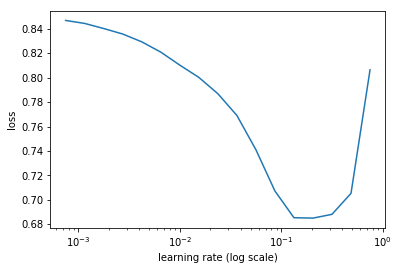

In [17]:
learn.sched.plot()

In [18]:
lr = 2e-2

In [19]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>   
    0      0.32721    0.151748   0.9506    
    1      0.17404    0.076578   0.9739    
    2      0.11752    0.074634   0.9743    



[array([0.07463]), 0.9743000059127808]

In [20]:
y = learn.predict()

In [21]:
x,_ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


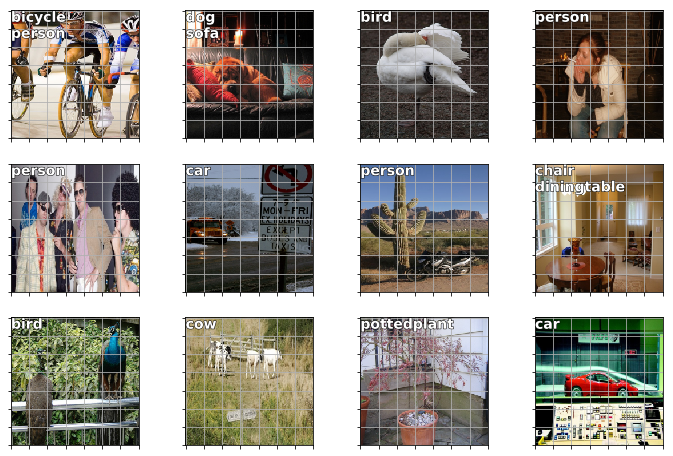

In [22]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i]>.4)[0]
    b = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)

## BBOX per cell

### Data setup

In [23]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model=resnet34
sz=224
bs=64

In [24]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc])

In [25]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [26]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)
df.head()

fn                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

In [27]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [28]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [29]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [30]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [31]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [32]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

In [33]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

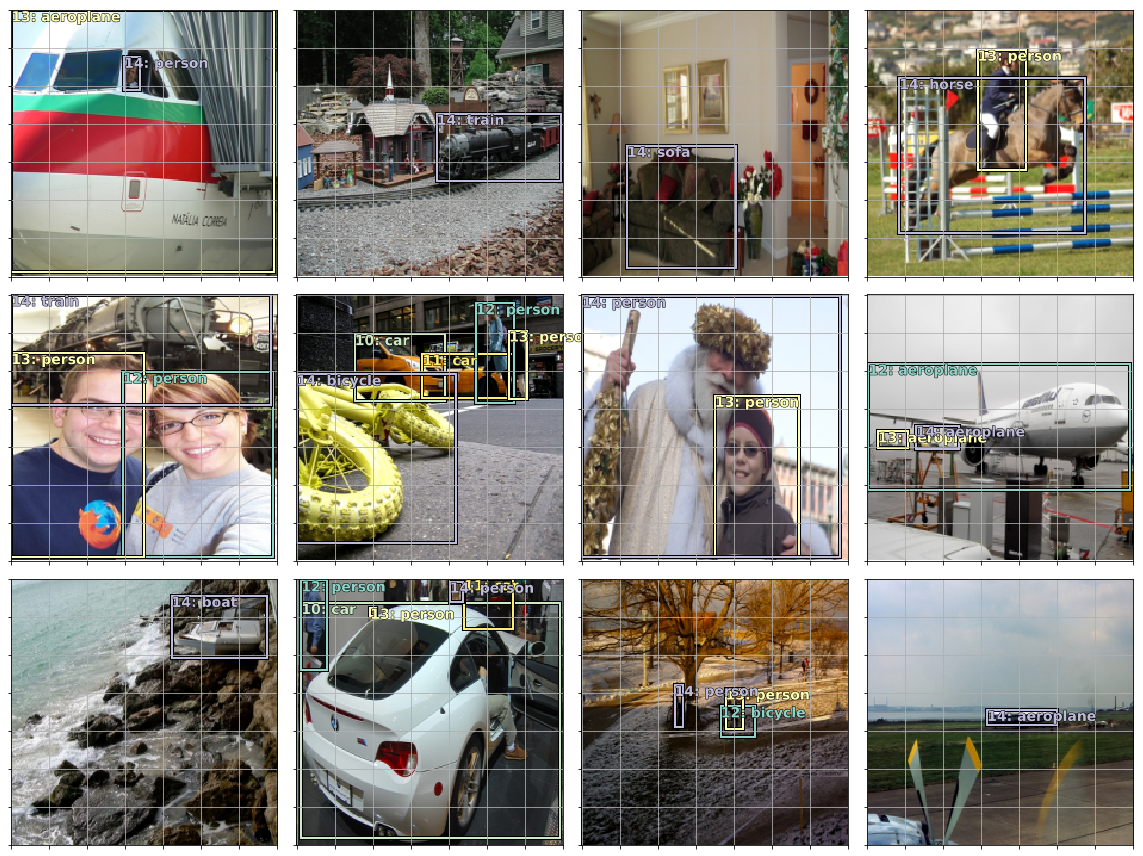

In [34]:
fig, axes = plt.subplots(3, 4, figsize=(16,12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax,x[i],y[0][i],y[1][i])
plt.tight_layout()

### Set up model

We're going to make a simple first model that simply predicts what object is located in each cell of a 4x4 grid. Later on we can try to improve this.

In [35]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [36]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

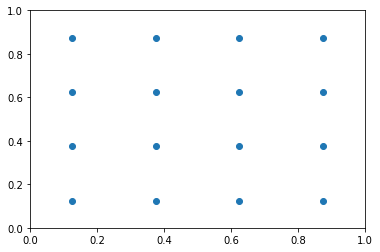

In [37]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [38]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [39]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [40]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [41]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

In [42]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [43]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [44]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

### Train

In [45]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [46]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [47]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [48]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)

In [49]:
x.shape, [o.shape for o in y]

(torch.Size([64, 3, 224, 224]), [torch.Size([64, 56]), torch.Size([64, 14])])

In [50]:
# for i,o in enumerate(y): y[i] = o.cpu()
# learn.model.cpu();

In [51]:
batch = learn.model(x)
[o.shape for o in batch]

[torch.Size([64, 16, 21]), torch.Size([64, 16, 4])]

In [52]:
ssd_loss(batch, y, True)


 0.1947
 0.1168
 0.2652
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.2885
 0.0888
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.9027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.1608
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3237
 0.2153
 0.2558
 0.2013
 0.2526
 0.0485
 0.0879
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3258
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2704
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.4538
 0.1897
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.1527
 0.1863
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3426
 0.3249
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.0642
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.2027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2418
 0.2337
 0.2590
[torch.cuda.FloatTensor of size 3 (GPU 0)]


1.00000e-02 *
  8.4642
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3652
 0.1377
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.5146
  5.739

Variable containing:
 83.5779
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [53]:
learn.crit = ssd_loss

In [54]:
learn.lr_find()

 84%|████████▍ | 27/32 [00:10<00:01,  2.61it/s, loss=313]

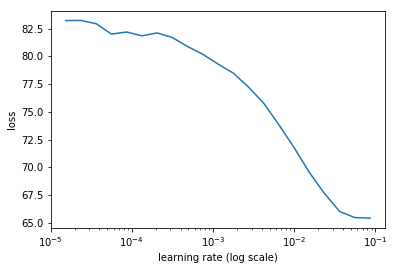

In [55]:
learn.sched.plot(1)

In [56]:
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

In [57]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

 75%|███████▌  | 24/32 [00:09<00:03,  2.59it/s, loss=49.4]

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/nathan/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/nathan/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/home/nathan/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   
    0      43.564175  32.444704 
    1      33.707792  28.657698 
    2      29.367572  27.094264 
    3      26.532401  26.435373 
    4      24.364602  25.794153 



[array([25.79415])]

In [58]:
x,y = next(iter(md.val_dl))

In [59]:
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)

In [61]:
b_clas, b_bb = batch

In [62]:
b_clas.size(), b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

In [66]:
# gt: ground truth
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()), to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [103]:
idx = 7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima = md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas,ima.shape

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)], (224, 224, 3))

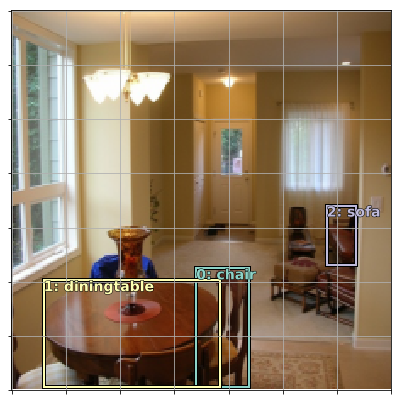

In [104]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

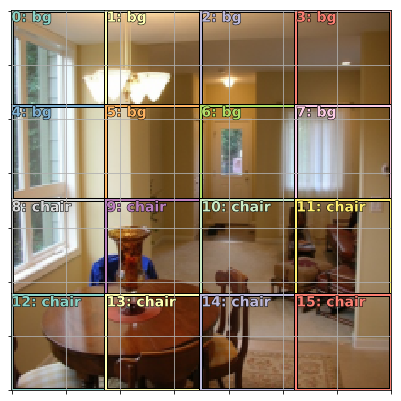

In [105]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [106]:
a_ic = actn_to_bb(b_bboxi, anchors); a_ic

Variable containing:
 0.0869  0.0593  0.2804  0.2908
 0.0976  0.3304  0.2541  0.5145
 0.0635  0.4818  0.3032  0.7617
 0.0759  0.8088  0.2201  0.9798
 0.3751  0.0870  0.5588  0.2167
 0.3828  0.3051  0.5444  0.4310
 0.3628  0.4991  0.5030  0.6260
 0.3630  0.7770  0.4913  0.9036
 0.4881  0.0650  0.8591  0.2930
 0.5278  0.2902  0.9026  0.4680
 0.5225  0.4912  0.8969  0.6724
 0.5173  0.7652  0.8501  0.9074
 0.6231  0.0107  0.9937  0.3389
 0.6080  0.1963  0.9829  0.5608
 0.6129  0.4050  0.9877  0.7626
 0.6471  0.7147  1.0107  0.9357
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

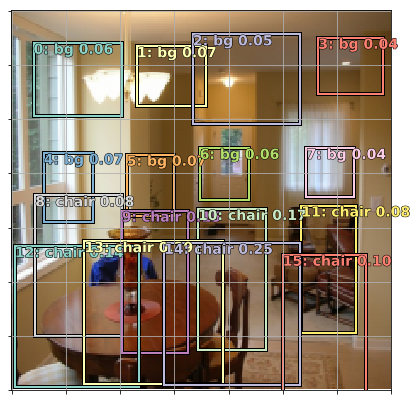

In [107]:
fix, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh = 0.0)

In [108]:
overlaps = jaccard(bbox.data, anchor_cnr.data); overlaps



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

In [109]:
overlaps.max(1)

(
  0.3985
  0.4538
  0.1897
 [torch.cuda.FloatTensor of size 3 (GPU 0)], 
  14
  13
  11
 [torch.cuda.LongTensor of size 3 (GPU 0)])

In [110]:
overlaps.max(0)

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  0.1897
  0.2598
  0.4538
  0.3985
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [111]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  1.9900
  0.2598
  1.9900
  1.9900
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

In [112]:
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]

In [117]:
thresh = 0.5
pos = gt_overlap > thresh

In [122]:
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx, neg_idx

(
  11
  13
  14
 [torch.cuda.LongTensor of size 3 (GPU 0)], 
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  12
  15
 [torch.cuda.LongTensor of size 13 (GPU 0)])

In [125]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o < len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

In [126]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs())
clas_loss = F.cross_entropy(b_clasi, gt_clas)
loc_loss, clas_loss

(Variable containing:
  0.0039  0.0652  0.1805  0.0011
  0.1018  0.1115  0.0081  0.0117
  0.0656  0.0816  0.0034  0.1376
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
  1.0362
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


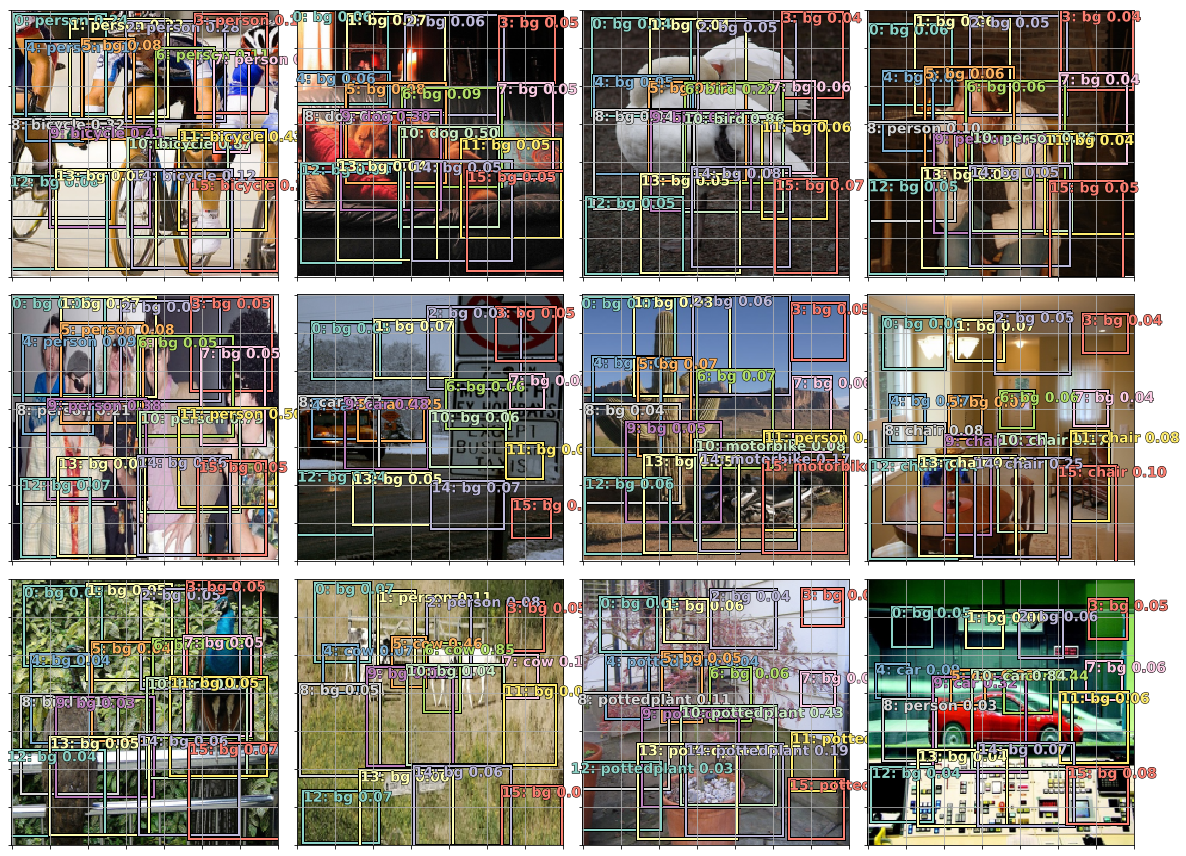

In [129]:
fig, axes = plt.subplots(3,4, figsize=(16,12))
for idx,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima=md.val_ds.ds.denorm(to_np(x))[idx]; bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()